# 0. Download and Pre-process data

Downloading geotechnical investigation data from Norways Database of Geotechnical Investigations (NADAG)

## 0.1 Downloading

#### Import Used Libraries 
Largely based on EMGeomodelling's open source libnadagclient package.

In [1]:
import requests_html
import requests
import os 
import zipfile
import io
import csv

from libnadagclient import get_project_info, get_project_ids_from_bounds, _get_project_zip_files, get_project_boreholes, get_borehole_info
import libsgfdata

Get the list of all NADAG project ids within the coordinate bounds. The coordinates used cover all of Norway (excluding Svalbard)

In [2]:
# norge = (-191816.36,6428340.61,1147981.52,7938521.6)
# proj_ids = get_project_ids_from_bounds(norge)

Download all zip files uploaded to NADAG for each project and write the asociated metadata for each borehole in each project to a csv.

In [3]:
# n = 5

# failed = {}

# folder_path = r"C:\Users\User1\Documents\NADAG DATA"

# for project_id in list(proj_ids.keys()):
#     try:
#         #Check if the folder exists
#         out_path = os.path.join(folder_path, project_id)

#         session = requests_html.HTMLSession()
#         info = get_project_info(project_id)
#         if zipfiles := _get_project_zip_files(info):
#             if not os.path.exists(out_path):
#                 os.mkdir(out_path)
#             for url in zipfiles:
#                 print(url)
#                 # Define a counter to keep track of the number of retries
#                 retry_count = 0
#                 # Loop until the request is successful or the number of retries exceeds n
#                 request_success = False
#                 while not request_success and retry_count <= n:
#                     try:
#                         # Attempt to make the request
#                         r = session.get(url)
#                         # If no exception is raised, set the flag to True and extract the zip file
#                         request_success = True
#                         zipf = zipfile.ZipFile(io.BytesIO(r.content))
#                         print(zipf)
#                         for name in zipf.namelist():
#                             zipf.extract(name, out_path)
#                     except requests.exceptions.ConnectionError as e:
#                         # If the exception is ConnectionError, print the error message and increment the retry count
#                         print(f"Error: {e}")
#                         print("Failed to make the request due to connection error.")
#                         retry_count += 1
#                         # If the number of retries exceeds n, add the project id and url to the failed dictionary
#                         if retry_count > n:
#                             if project_id not in failed.keys():
#                                 failed[project_id] = []
#                             failed[project_id].append(url)

#             borehole_map = get_project_boreholes(project_id)

#             with open("hole_data.csv", "a",newline='') as borecsvfile:

#                 #Create a csv writer object

#                 borewriter = csv.writer(borecsvfile)
#                 for val in borehole_map.values():
#                     session = requests_html.HTMLSession()
#                     # Define a counter to keep track of the number of retries
#                     retry_count = 0
#                     # Loop until the request is successful or the number of retries exceeds n
#                     request_success = False
#                     while not request_success and retry_count <= n:
#                         try:
#                             # Attempt to get the borehole info
#                             bh_info = get_borehole_info(val)
#                             # If no exception is raised, set the flag to True and write to the csv file
#                             request_success = True
#                             out_list = [project_id, *list(bh_info.values())]
#                             borewriter.writerow(out_list)
#                         except requests.exceptions.ConnectionError as e:
#                             # If the exception is ConnectionError, print the error message and increment the retry count
#                             print(f"Error: {e}")
#                             print("Failed to get the borehole info due to connection error.")
#                             retry_count += 1
#                             # If the number of retries exceeds n, add the project id and val to the failed dictionary
#                             if project_id not in failed.keys():
#                                 failed[project_id] = []
#                             failed[project_id].append(val)
#     except:
#         if project_id not in failed.keys():
#             failed[project_id] = []
#         failed[project_id].append("failure general")

## 0.2 Data Processing

#### Import Used Libaries

In [4]:
from os import listdir, walk
from os.path import isfile, join
from difflib import get_close_matches

from rdp import rdp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Load the downloaded metadata

In [5]:
hole_data_df = pd.read_csv(r"C:\Users\User1\Documents\NADAG DATA\hole_data.csv", header=None)
hole_data_df.columns = [
    'prosjekt_id',
    'borenr',
    'antallborhullundersoekelser',
    'koord',
    'hoeyde',
    'boredato',
    'oppdragstaker',
    'oppdragsgiver',
    'prosjektnavn',
    'prosjektnr',
    'merknad',
    'Maks boret lengde (m)',
    'p_dyp',
    'kvikkleirepaavisning',
    'boreprofil',
    'Metoder',
    'report',
 ]

Process the location of the data and plot

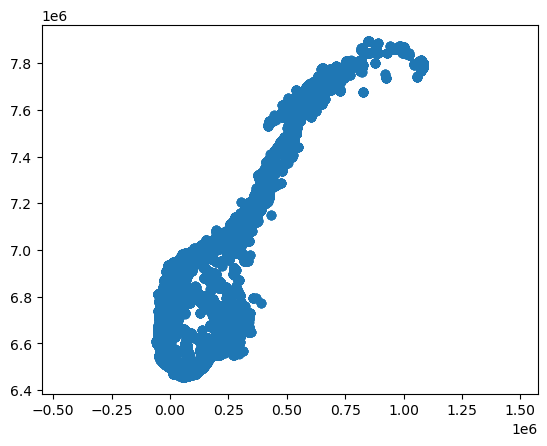

In [6]:
# Split the koord column by space and assign to two new columns
hole_data_df[['x_coordinate', 'y_coordinate']] = hole_data_df['koord'].str.split(' ', expand=True)
hole_data_df["z_coordinate"] = hole_data_df['hoeyde'].str.split(' ', expand=True)[0]
# Remove the :E and :N suffixes from the new columns
hole_data_df['x_coordinate'] = hole_data_df['x_coordinate'].str.replace(':E', '')
hole_data_df['y_coordinate'] = hole_data_df['y_coordinate'].str.replace(':N', '')
# Convert the new columns to numeric values
hole_data_df['x_coordinate'] = pd.to_numeric(hole_data_df['x_coordinate'])
hole_data_df['y_coordinate'] = pd.to_numeric(hole_data_df['y_coordinate'])
hole_data_df['z_coordinate'] = pd.to_numeric(hole_data_df['z_coordinate'])

#Remove one oddly placed boring
hole_data_df = hole_data_df[hole_data_df["y_coordinate"] != hole_data_df["y_coordinate"].min()]

plt.scatter(hole_data_df["x_coordinate"],hole_data_df["y_coordinate"])
plt.gca().axis('equal')
plt.show()

Unzip all zipped subfolders

In [7]:
# path = r"C:\Users\User1\Documents\NADAG DATA"
# extension = ".ZIP"
# zip_files = []
# for dirpath, dirnames, filenames in walk(path):
#     zip_files.extend(
#         join(dirpath, f) for f in filenames if extension in f.upper()
#     )
# for file in zip_files:
#     try:
#         with zipfile.ZipFile(file, 'r') as zip_ref:
#             zip_ref.extractall(file.strip(".zip"))
#     except Exception:
#         pass

### 0.2.1 Process ".sgf" files and save as ".tot" or ".cpt" 

In [8]:
# path = r"C:\Users\User1\Documents\NADAG DATA"
# extension = ".STD"
# std_files = []
# for dirpath, dirnames, filenames in walk(path):
#     std_files.extend(
#         join(dirpath, f) for f in filenames if extension in f.upper()
#     )
    
# for std_file in std_files:
#     prosjekt_id = std_file.split(path)[-1].split("\\")[1]
#     try:
#         with open(std_file,'r') as f:
#             filedata = f.read()

#         newdata = filedata.replace('F=', 'FS=')
#         newdata = newdata.replace('Q=', 'QC=')

#         with open("temp.std",'w') as f:
#             f.write(newdata)

#         sgf_data = libsgfdata.SGFData('temp.std', normalize=True)
#     except Exception:
#         print("Could not read", std_file)
#         continue
#     for (_, group), (_,meta) in zip(sgf_data.data.groupby("investigation_point"),sgf_data.main.groupby("investigation_point")):
#         b = libsgfdata.SGFData()
#         b.data = group
#         b.main = meta

#         prefix_dict = {"total":".tot","cpt":".cpt"}

#         prefix = prefix_dict.get(meta["method_code"].values[0], ".sgf")
#         if not os.path.exists(join("std_sorted",prosjekt_id)): os.mkdir(join("std_sorted",prosjekt_id))
#         try:
#             b.dump(join("std_sorted",prosjekt_id,str(group.investigation_point[0])+prefix))
#         except:
#             print("Could not write", str(join("std_sorted",prosjekt_id,str(group.investigation_point[0])+prefix)))


### 0.2.2 Associate total sounding data from ".tot" files with the hole data metadata

In [9]:
def associate_file_investigation_point(hole_data_df,extension = ".TOT", basepath = "",cutoff=0.85):
    methods = {
        ".CPT":"Trykksondering",
        ".TOT":"Totalsondering",
                }

    sgf_methods = {
        "total":".TOT",
        "cpt":".CPT"

    }

    pattern = r"\(([^)]+)(?!\.)\)"
    df = pd.DataFrame()
    total_files = 0
    num_groups = len(hole_data_df.groupby(by ="prosjekt_id"))
    num = 1
    for name, project in hole_data_df.groupby(by ="prosjekt_id"):
        print(num,"/", num_groups, "groups")
        loops = [".CPT",".TOT"] if extension == ".STD" else [extension]
        for loop in loops:
            group = project.copy(deep = True)
            group = group[group["Metoder"].str.contains(methods[loop],na=False)]
            path =  join(basepath,f"{name}")
            files = []
            for dirpath, _, filenames in walk(path):
                files.extend(join(dirpath, f) for f in filenames if extension in f.upper ())
            total_files += len(files)
            names = []
            for file in files:
                try:
                    sgf_data = libsgfdata.SGFData(join(file), normalize=True)
                    if sgf_methods[sgf_data.main["method_code"][0]] == loop:
                        names.append(str(sgf_data.main["investigation_point"][0]))
                    else:
                        names.append(np.nan)
                except Exception:
                    names.append(np.nan)

            group["file_associated"] = group["boreprofil"].str.extract(pattern)
            group["file_associated"] = group["file_associated"].str.split(".").str[0]
            group["file_associated"] = group["file_associated"].str.replace(r"[a-zA-Z]", "",regex=True)
            group["file_associated"] = group["file_associated"].str.replace(r"[^\w\s]", "-",regex=True)
            files_list = []
            inv_points = []

            for b in group["file_associated"]:
                success = False
                if b:
                    try:
                        match = get_close_matches(b,names,cutoff=cutoff,n=1)
                        if len(match) > 0: # check if match is not empty
                            file = files[names.index(match[0])]
                            files_list.append(file)
                            success = True
                        else: # handle the case when no match is found
                            files_list.append(np.nan)
                            inv_points.append(np.nan)
                    except Exception:
                        files_list.append(np.nan)
                        inv_points.append(np.nan)
                    if success:
                        try:
                            inv_points.append(match[0])
                        except Exception:
                            inv_points.append(np.nan)
                else:
                    files_list.append(np.nan)
                    inv_points.append(np.nan)
            group["file"]= files_list
            group["investigation_point"] = inv_points
            group = group.dropna(subset="file")
            df = pd.concat([df,group])        
        num += 1
    print("Assigned", len(df), "of", total_files,extension," files found")  
    return df

In [10]:
# tot_df = associate_file_investigation_point(hole_data_df,extension = ".TOT", basepath = r"C:\Users\User1\Documents\NADAG DATA",cutoff=0.85)
# tot_df.to_csv("tot_assigned.csv")

tot_df = pd.read_csv("tot_assigned.csv")

### 0.2.3 Associate cpt data from ".cpt" files with the hole data metadata

In [11]:
# cpt_df = associate_file_investigation_point(hole_data_df,extension = ".CPT", basepath = r"C:\Users\User1\Documents\NADAG DATA",cutoff=0.85)
# cpt_df.to_csv("cpt_assigned.csv")

cpt_df = pd.read_csv("cpt_assigned.csv")

### 0.2.4 Process Sample Data

#### 0.2.3.1 Read ".rla" and ".prv" files

RLA

In [12]:
def read_rla(rla_file):

    df = pd.DataFrame(columns = ["rla_file","prosjekt_id","investigation_point","sample_type","start_depth","end_depth","result_type","result_value"])

    result_types = ["Classification", #0
                    "Loss on Ignition",  #1
                    "Density",  #2
                    "Water Content",  #3
                    "Plastic Limit",  #4
                    "Liquid Limit",  #5
                    "Uniaxial",  #6
                    "Uniaxial Strain",  #7
                    "Cone Remoulded",   #8
                    "Cone Undisturbed", #9
                    "None"]

    sample_types = ["Poseprøve","54 mm","None"]

    opened_file = open(rla_file,"r")
    lines = opened_file.readlines()

    prosjekt_id = rla_file.split(path)[-1].split("\\")[1]

    rla_name = rla_file.split("Hu")[-1].split('\\')[-1].split(".")[0]
    for c in rla_name:
        if c.isdigit():
            i = rla_name.find(c) # get the index of the first digit
            investigation_point = rla_name[i:] # slice from that index onwards
            break

    for i, line in enumerate(lines):
        clean_string = re.sub (' +', ' ', line)
        clean_string = clean_string.strip('\n')
        list_line = clean_string.split(" ")
        if i == 0:
            sample_type = get_close_matches(str(list_line[2]),sample_types,cutoff=0.3,n=1)
            sample_type = sample_type[0] if sample_type else np.nan
        elif clean_string[0] == " ":
            start_depth = float(list_line[2])
            end_depth = float(list_line[3])
            output_base = [rla_file,prosjekt_id,investigation_point,sample_type,start_depth,end_depth]

            if float(list_line[4]) != 0:
                df.loc[len(df)] = [*output_base,result_types[2],float(list_line[4])]
            if float(list_line[5]) != 0:
                df.loc[len(df)] = [*output_base,result_types[1],float(list_line[5])]
            if list_line[6] != "":
                df.loc[len(df)] = [*output_base,result_types[0]," ".join(list_line[6:])]

        else:
            start_depth = end_depth = float(list_line[0])
            output_base = [rla_file,prosjekt_id,investigation_point,sample_type,start_depth,end_depth]
            if float(list_line[1]) != 0:
                df.loc[len(df)] = [*output_base,result_types[3],float(list_line[1])]
            if float(list_line[2]) != 0:
                df.loc[len(df)] = [*output_base,result_types[4],float(list_line[2])]
            if float(list_line[3]) != 0:
                df.loc[len(df)] = [*output_base,result_types[5],float(list_line[3])]
            if float(list_line[4]) != 0:
                df.loc[len(df)] = [*output_base,result_types[6],float(list_line[4])]
            if float(list_line[5]) != 0:
                df.loc[len(df)] = [*output_base,result_types[7],float(list_line[5])]
            if float(list_line[6]) != 0:
                df.loc[len(df)] = [*output_base,result_types[9],float(list_line[6])]
            if float(list_line[7]) != 0:
                df.loc[len(df)] = [*output_base,result_types[8],float(list_line[7])]
    return df

def read_rla_sample_files(path):
    extension = ".RLA"
    rla_files = []

    for dirpath, dirnames, filenames in walk(path):
        for f in filenames:
            if extension in f.upper ():
                rla_files.append (join(dirpath, f))

    sample_df = pd.DataFrame()

    print(len(rla_files), " files found")
    for i, rla_file in enumerate(rla_files):
        print(i, "/", len(rla_files))
        try:
            new_df = read_rla(rla_file)
            sample_df = pd.concat([new_df,sample_df])
        except Exception:
            print("failed",rla_file)

    sample_df.to_csv("samples_sorted.csv")
    return sample_df

path =r"C:\Users\User1\Documents\NADAG DATA"

# sample_df = read_rla_sample_files(path)

sample_df = pd.read_csv("samples_sorted.csv")
sample_df.head()

,Unnamed: 0,rla_file,prosjekt_id,investigation_point,sample_type,start_depth,end_depth,result_type,result_value
0,0,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,0.0,1.0,Loss on Ignition,57.2
1,1,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,0.0,1.0,Classification,Humus
2,2,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,0.5,0.5,Water Content,589.2
3,3,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,1.0,2.0,Loss on Ignition,81.6
4,4,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,1.0,2.0,Classification,Humus


PRV (TODO) - not as many samples, low priority

### 0.2.3.2 Process sample descriptions 

Use turbo-3.5-turbo to parse sample visual descriptions into a list of components in descending order of relevance.

In [13]:
import openai
import ast

# Set up your OpenAI API credentials
openai.api_key = ''

def parse_description(description):
    response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
            {"role": "system", "content":
            "Task: Parse soil description and return primary and secondary, and other components."
            "You are the world's best geotechnical engineer, you can speak Norwegian and English. If I give you a visual classification, I want you to return the primary and secondary components (if relevant, or more) in English."            
            "The component should be one of ['sand', 'gravel', 'silt', 'clay', 'humus']."
            "To help refer to NGF melding 2 which states:"
            "Secondary and lower fractions are described in adjective form, and are placed in order of their relevance "
            "Norwegian adjectives often contain the letters 'ig' so if it says - for example - 'Sandig', 'leirig', 'siltig' or 'grusig' these are in adjective form and it is a secondary component"
            "The main component often is stated at the end in verb form"
            "If it contains the words von Post, or H# where # is a number it is humus"
            "Dont return extra text, you are efficent, only return a list with the primary and secondary, and additional components as neccisary"},
            {"role": "user", "content": "Sandig siltig grusig matriale, h "},
            {"role": "assistant", "content": "['sand','gravel']"},
            {"role": "user", "content": "Sandig leirig silt"},
            {"role": "assistant", "content": "['silt','sand', 'clay]"},
            {"role": "user", "content": "Siltig leire"},
            {"role": "assistant", "content": "['clay','silt']"},
            {"role": "user", "content": "Sandig grus"},
            {"role": "assistant", "content": "['gravel','sand']"},
            {"role": "user", "content": description.strip()}
        ],
    temperature = 0.1
    )
    result = response['choices'][0]['message']['content']
    
    return ast.literal_eval(result)


In [14]:
classification_df = sample_df[sample_df["result_type"]=="Classification"]
# soil_descriptions = {}
# descriptions = list(classification_df["result_value"].unique())
# num_descriptions = len(descriptions)
# for i, description in enumerate(descriptions):
#     print(i+1, "/", num_descriptions)
#     try:
#         soil_descriptions[description] = parse_description(description)
#     except Exception:
#         soil_descriptions[description] = np.nan

In [15]:
import pickle
with open('soil_descriptions_big2.pickle', 'rb') as f:
    soil_descriptions = pickle.load(f)

classification_df["components"] = classification_df["result_value"].map(soil_descriptions)
classification_df.head()

C:\Users\lfabbri\AppData\Local\Temp\ipykernel_15440\1046821567.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  classification_df["components"] = classification_df["result_value"].map(soil_descriptions)


,Unnamed: 0,rla_file,prosjekt_id,investigation_point,sample_type,start_depth,end_depth,result_type,result_value,components
1,1,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,0.0,1.0,Classification,Humus,[humus]
4,4,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,1.0,2.0,Classification,Humus,[humus]
7,7,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,2.0,3.0,Classification,"Torv og leire, humusholdig","[clay, humus]"
10,10,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13012,Poseprøve,3.0,4.0,Classification,"Siltig leire, humusholdig","[clay, silt, humus]"
13,1,C:\Users\User1\Documents\NADAG DATA\ffedfa3d-7...,ffedfa3d-7b82-455d-8581-d990a92a22f6,13004,Poseprøve,0.0,1.0,Classification,Humus,[humus]


### 0.2.3.4 Extract Data from grain size distribution curves

In [16]:
# import fitz
# import copy

# from IPython.display import display
# from PIL import Image

# grain_size_df = pd.DataFrame()

# len_grain_size = len(grain_size_files)
# count=1
# for pdffile in grain_size_files:
#     count+=1
#     print(count,"/",len_grain_size)
#     prosjekt_id = pdffile.split(path)[-1].split("\\")[1]
#     if ".pdf" in pdffile.lower():
#         doc = fitz.open(pdffile)
#         for page in doc:
#             # page = doc.load_page(0)  # number of page
#             # pix = page.get_pixmap()
#             # img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
#             # display(img)

#             # Find the hole number:
#             hull_nr_rect = page.search_for("Hullnr")
#             if hull_nr_rect:
#                 rect = hull_nr_rect[0]
#                 if rect:
#                     rect.x1 = rect.x1 +100
#                     header = page.get_textbox(rect)

#                     colon = header.find(':')
#                     comma = header.find(',')
#                     number = header[colon+1:comma].strip()

#                     #TODO: Find ones that have hul in the result, find ones with proveserie.
#                     # if "hul" in number.lower():
#                     #     number = re.findall("\d+", number)

#                     # print("hull",number)
#             # Find the sample numbers:
#             #TODO: Find ones that have Syl as the header for pr;venumbr.
#             prove_rect = page.search_for("Prøvenr.")
#             if prove_rect:
#                 rect = prove_rect[-1]
#                 rect.y1 = rect.y1 +1000
#                 rect.x1 = rect.x1 +20
#                 samples = page.get_textbox(rect)
#                 if "Sted" in "".join(samples):
#                     samples = samples.strip().split('\n')[2:-1]
#                     # print("samples", samples)

#                     #Find the grain size measurements and their x position
#                     pr_nr_rect = page.search_for("Pr.nr.")
#                     if prove_rect:
#                         words = page.get_text("words")
#                         rect = pr_nr_rect[0]
#                         rect.x1 = rect.x1 +1000
#                         screens_list = [w for w in words if fitz.Rect(w[:4]) in rect]
#                         screens_list = [screen for screen in screens_list if screen[4] != 'Pr.nr.']
#                         screens_list_mm = list(filter(None, [float(screen[4]) if screen[4] != 'Pr.nr.' else None for screen in screens_list]))
#                         screens_list_orig = copy.deepcopy(screens_list_mm)

#                         def append_or_divide_and_append(toggle,value,list_adj,denom = 1000):
#                             if toggle:
#                                 list_adj.append(float(value)/denom)
#                             else:
#                                 list_adj.append(float(value))
#                             return list_adj

#                         screens_cleaned = []
#                         um_toggle = True
#                         for i, screen in enumerate(screens_list_orig):
#                             if i == len(screens_list_orig)-1:# Todo catch this if its good
#                                 screens_cleaned = append_or_divide_and_append(um_toggle,screen,screens_cleaned)
#                                 break
#                             elif um_toggle:
#                                 if i > screens_list_orig[i+1]:
#                                     screens_cleaned = append_or_divide_and_append(um_toggle,screen,screens_cleaned)
#                                     um_toggle = False
#                                     continue
#                             screens_cleaned = append_or_divide_and_append(um_toggle,screen,screens_cleaned)

#                         screens_list_mm = screens_cleaned
#                         screens_mm_dict = {k:v for (k,v) in zip (screens_list_orig, screens_list_mm)}
#                         screens_x0_dict = {float(screen[0]):float(screen[4]) for screen in screens_list}
                    
#                     #Find where the text Middels is on the page to get the sample number y positions
#                     middels_rect = page.search_for("Middels")
#                     if middels_rect:
#                         pr_nr_rect_obj = page.search_for("Pr.nr.")[0]
#                         middels_rect = middels_rect[0]
#                         middels_rect.x0 = pr_nr_rect_obj.x0
#                         middels_rect.x1 = pr_nr_rect_obj.x1
#                         middels_rect.y0 = pr_nr_rect_obj.y1
#                         middels_rect.y1 = middels_rect.y1 - 20
#                         words = page.get_text("words")
#                         sample_headers = [w for w in words if fitz.Rect(w[:4]) in middels_rect]
#                         sample_headers_y0_dict = {float(head[1]):head[4] for head in sample_headers}

#                         #Get all the results with x y positions 
#                         pr_nr_rect_obj.x0 = pr_nr_rect_obj.x0 + 50
#                         pr_nr_rect_obj.x1 = pr_nr_rect_obj.x1 + 1000
#                         pr_nr_rect_obj.y0 = pr_nr_rect_obj.y0 +5
#                         pr_nr_rect_obj.y1 = middels_rect.y1
#                         results = [w for w in words if fitz.Rect(w[:4]) in pr_nr_rect_obj]

                    
#                 # Find the depths:
#                 dybde_rect = page.search_for("Dybde")
#                 if dybde_rect:
#                     rect = dybde_rect[0]
#                     rect.y1 = rect.y1 +1000
#                     rect.x1 = rect.x1 +20
#                     depths = page.get_textbox(rect)
#                     depths = depths.split('\n')
#                     depths = [depth for depth in depths if "." in depth]
#                     # print("depths", depths)

#                 summary = {}
#                 for result in results:
#                     if result[4] not in [*list(screens_x0_dict.values()),*list(sample_headers_y0_dict.values())]:
#                         x = result[0]
#                         y = result[1]
#                         value = result[4]
#                         closest_screen = screens_x0_dict[min(list(screens_x0_dict.keys()),key = lambda x0: abs(x0-x))]
#                         closest_sample = sample_headers_y0_dict[min(list(sample_headers_y0_dict.keys()),key = lambda y0: abs(y0-y))]

#                         if closest_sample not in summary.keys():
#                             summary[closest_sample] = {}
#                         summary[closest_sample][screens_mm_dict[float(closest_screen)]] = float(value)
                        
#                 results_df = pd.DataFrame(summary).T
#                 results_df["prosjekt_id"] = prosjekt_id
#                 results_df["investigation_point"] = number
#                 try:
#                     results_df["depths"] = depths
#                 except:
#                     results_df["depths"] = np.nan
                
#                 grain_size_df = pd.concat([grain_size_df,results_df])
#                 # print(results_df)
#             else:
#                 continue

# grain_size_df.to_csv("grain_size_df.csv")
grain_size_df = pd.read_csv("grain_size_df.csv")
grain_size_df.head()

,Unnamed: 0,0.063,0.125,0.25,0.5,1.0,2.0,4.0,8.0,16.0,...,5.6,45.0,0.001,0.002,0.004,0.008,0.016,0.02,0.0224,0.0315
0,1,16.3,36.9,58.4,82.4,96.7,99.5,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,8.4,26.3,66.3,92.5,99.1,99.9,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1B,86.1,87.4,87.8,88.1,89.0,89.8,90.2,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2B,97.9,98.3,98.5,98.8,99.2,99.6,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3A,99.1,99.9,100.0,100.0,100.0,100.0,100.0,100.0,100.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
